In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import gurobipy as gp
from gurobipy import GRB
from numpy.typing import NDArray

In [2]:
# 価格を生成する関数
def create_price(r_min: float, r_max: float, M: int) -> NDArray[np.float_]:
    # r_minとr_maxの間のランダムな0.1刻みの少数をM個生成
    price = np.random.uniform(r_min, r_max, M)
    price = np.round(price, 1)

    return price


# alphaを作成する関数
def alpha_star(M: int) -> NDArray[np.float_]:
    alpha_star = np.random.uniform(M, 3 * M, size=M)
    return alpha_star


# betaを作成する関数
def beta_star(M: int, M_prime: int) -> NDArray[np.float_]:
    beta_star = np.zeros((M, M_prime))

    for m in range(M):
        for m_prime in range(M_prime):
            if m == m_prime:
                beta_star[m, m_prime] = np.random.uniform(-2 * M, -M)
            else:
                beta_star[m, m_prime] = np.random.uniform(0, 2)

    return beta_star


def quantity_function(
    price: NDArray[np.float_], alpha: NDArray[np.float_], beta: NDArray[np.float_]
) -> list[float]:
    M = len(price)
    quantity_list = []

    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]

        quantity = alpha[m] + sum_beta
        quantity_list.append(quantity)

    return quantity_list


def sales_function(
    price: NDArray[np.float_], alpha: NDArray[np.float_], beta: NDArray[np.float_]
) -> list[float]:
    M = len(price)
    sales_list = []

    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]

        quantity = alpha[m] + sum_beta
        sales_list.append(quantity * price[m])

    return sales_list

In [3]:
# 予測と最適化を行う関数
def predict_optimize(
    M: int, X: NDArray[np.float_], Y: NDArray[np.float_], prices_list: list[float]
) -> tuple[float, NDArray[np.float_]]:
    lr = MultiOutputRegressor(LinearRegression())
    lr.fit(X, Y)

    Z = len(prices_list)

    # 係数と切片を取得
    coefs = [estimate.coef_ for estimate in lr.estimators_]
    intercepts = [estimate.intercept_ for estimate in lr.estimators_]

    # 予測を最適化

    # gurobiのモデルを作成
    model = gp.Model()

    # 変数を作成
    # prices = model.addVars(M, lb=6, ub=10, vtype=GRB.INTEGER, name="prices")
    x = model.addVars(M, Z, vtype=GRB.BINARY, name="x")

    # 制約を設定
    for i in range(M):
        model.addConstr(gp.quicksum(x[i, j] for j in range(Z)) == 1)

    # 目的関数を設定
    total_sales = 0
    for i in range(M):
        total_sales += gp.quicksum(
            (
                (
                    gp.quicksum(coefs[i][j] * prices_list[k] * x[j, k] for j in range(M))
                    + intercepts[i]
                )
                * prices_list[k]
                * x[i, k]
            )
            for k in range(Z)
        )
    model.setObjective(total_sales, GRB.MAXIMIZE)

    # 最適化
    model.optimize()

    optimal_sales = model.objVal

    # 最適化結果の価格を取得
    optimal_prices = []
    for i in range(M):
        for j in range(Z):
            if x[i, j].x > 0.5:  # バイナリ変数が1ならその価格を選択
                optimal_prices.append(prices_list[j])

    return optimal_sales, optimal_prices

In [4]:
# sales_functionの最適化を行う関数
def sales_optimize(
    M: int, alpha: NDArray[np.float_], beta: NDArray[np.float_], prices_list: list[float]
) -> tuple[float, NDArray[np.float_]]:
    # モデルの作成
    model = gp.Model()

    Z = len(prices_list)

    # 変数を作成
    # prices = model.addVars(M, lb=6, ub=10, vtype=GRB.INTEGER, name="prices")
    x = model.addVars(M, Z, vtype=GRB.BINARY, name="x")

    # 制約を設定
    for i in range(M):
        model.addConstr(gp.quicksum(x[i, j] for j in range(Z)) == 1)

    # 目的関数の設定
    objective = 0
    for m in range(M):
        objective += gp.quicksum(
            (
                alpha[m]
                + gp.quicksum(
                    beta[m][m_prime] * prices_list[j] * x[m_prime, j] for m_prime in range(M)
                )
            )
            * prices_list[j]
            * x[m, j]
            for j in range(Z)
        )

    model.setObjective(objective, GRB.MAXIMIZE)

    # 最適化
    model.optimize()

    # 結果を取得
    optimal_sales = model.objVal

    # 最適化結果の価格を取得
    optimal_prices = []
    for i in range(M):
        for j in range(Z):
            if x[i, j].x > 0.5:  # バイナリ変数が1ならその価格を選択
                optimal_prices.append(prices_list[j])

    return optimal_sales, optimal_prices

In [5]:
# CVを行う関数
def cross_validation(
    X: NDArray[np.float_], y: NDArray[np.float_], M: int, K: int, prices_list: list[float]
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []
    Z = len(prices_list)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # モデルの作成
        model = gp.Model()

        # 変数を作成
        # prices = model.addVars(M, lb=6, ub=10, vtype=GRB.INTEGER, name="prices")
        x = model.addVars(M, Z, vtype=GRB.BINARY, name="x")
        # 制約を設定
        for i in range(M):
            model.addConstr(gp.quicksum(x[i, j] for j in range(Z)) == 1)

        # 目的関数を設定
        total_sales = 0
        for i in range(M):
            total_sales += gp.quicksum(
                (
                    (
                        gp.quicksum(coefs[i][j] * prices_list[k] * x[j, k] for j in range(M))
                        + intercepts[i]
                    )
                    * prices_list[k]
                    * x[i, k]
                )
                for k in range(Z)
            )
        model.setObjective(total_sales, GRB.MAXIMIZE)

        # 最適化
        model.optimize()

        # 最適化結果の価格を取得
        optimal_prices = []
        for i in range(M):
            for j in range(Z):
                if x[i, j].x > 0.5:  # バイナリ変数が1ならその価格を選択
                    optimal_prices.append(prices_list[j])
        optimal_prices = np.array(optimal_prices)

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return np.mean(optimal_sales_list)

In [6]:
# このデータにおけるalpha,betaを作成
M = 20
alpha = alpha_star(M)
beta = beta_star(M, M)
r_m = 0.6
r_M = 1.0
# 価格を入れるリスト
price_list = []
# 売上を入れるリスト
sales_list = []

# 価格と対応する売上を500件生成
for i in range(500):
    price = create_price(r_m, r_M, M)
    price_list.append(price)
    sales = quantity_function(price, alpha, beta)
    sales_list.append(sales)

X = np.array(price_list).astype(float)
y = np.array(sales_list).astype(float)

In [7]:
z = [0.6, 0.7, 0.8, 0.9, 1.0]

In [8]:
predict_optimize(M, X, y, z)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-27
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 20 rows, 100 columns and 100 nonzeros
Model fingerprint: 0x42a6836e
Model has 1050 quadratic objective terms
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 6e+01]
  QObjective range [2e-01, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 443.0724572
Presolve time: 0.01s
Presolved: 20 rows, 100 columns, 100 nonzeros
Presolved model has 1050 quadratic objective terms
Variable types: 0 continuous, 100 integer (100 binary)

Root relaxation: objective 6.622254e+02, 142 iteration

(662.2253403772511,
 [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0])

In [9]:
sales_optimize(M, alpha, beta, z)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 20 rows, 100 columns and 100 nonzeros
Model fingerprint: 0x62658ff2
Model has 1050 quadratic objective terms
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 6e+01]
  QObjective range [2e-01, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 443.0724572
Presolve time: 0.00s
Presolved: 20 rows, 100 columns, 100 nonzeros
Presolved model has 1050 quadratic objective terms
Variable types: 0 continuous, 100 integer (100 binary)

Root relaxation: objective 6.622254e+02, 142 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds

(662.2253403772513,
 [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0])

In [10]:
cross_validation(X, y, M, 5, z)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 20 rows, 100 columns and 100 nonzeros
Model fingerprint: 0xca243b36
Model has 1050 quadratic objective terms
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 6e+01]
  QObjective range [2e-01, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 443.0724572
Presolve time: 0.00s
Presolved: 20 rows, 100 columns, 100 nonzeros
Presolved model has 1050 quadratic objective terms
Variable types: 0 continuous, 100 integer (100 binary)

Root relaxation: objective 6.622254e+02, 142 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds

662.2253403772515

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 20 rows, 100 columns and 100 nonzeros
Model fingerprint: 0x42a6836e
Model has 1050 quadratic objective terms
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 6e+01]
  QObjective range [2e-01, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 443.0724572
Presolve time: 0.00s
Presolved: 20 rows, 100 columns, 100 nonzeros
Presolved model has 1050 quadratic objective terms
Variable types: 0 continuous, 100 integer (100 binary)

Root relaxation: objective 6.622254e+02, 142 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds

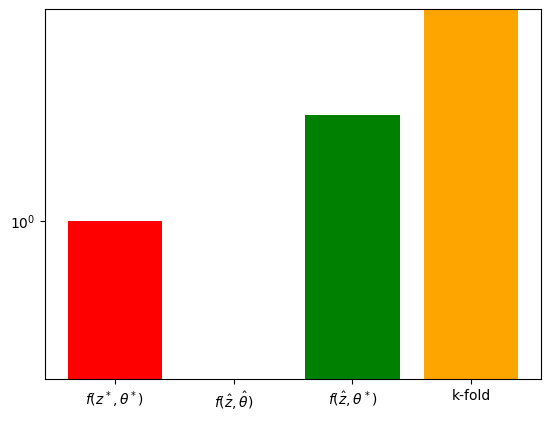

In [17]:
# predict_optimazeの結果を取得
predict_optimize_sales, predict_optimize_prices = predict_optimize(M, X, y, z)
# sales_optimizeの結果を取得
sales_optimize_sales, sales_optimize_prices = sales_optimize(M, alpha, beta, z)
# cross_validationの結果を取得
cross_validation_sales = cross_validation(X, y, M, 5, z)

# predictoptimize_salesをsales_functionに代入
predict_sales = sum(sales_function(predict_optimize_prices, alpha, beta))

# 結果を図示
plt.bar(
    [r"$f(z^*,\theta^*)$", r"$f(\hat{z},\hat\theta)$", r"$f(\hat{z},\theta^*)$", r"k-fold"],
    [
        sales_optimize_sales / sales_optimize_sales,
        predict_optimize_sales / sales_optimize_sales,
        predict_sales / sales_optimize_sales,
        cross_validation_sales / sales_optimize_sales,
    ],
    color=["red", "blue", "green", "orange"],
)
plt.yscale("log")

plt.show()

In [12]:
print("predict_optimize_sales:", predict_optimize_sales)
print("sales_optimize_sales:", sales_optimize_sales)

print("predict_sales:", predict_sales)
print("cross_validation_sales:", cross_validation_sales)

predict_optimize_sales: 662.2253403772511
sales_optimize_sales: 662.2253403772513
predict_sales: 662.2253403772514
cross_validation_sales: 662.2253403772515


In [149]:
print("predict_optimize_prices:", predict_optimize_prices)

predict_optimize_prices: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [150]:
print("sales_optimize_prices:", sales_optimize_prices)

sales_optimize_prices: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [151]:
# M=2で実験
M = 2
alpha = alpha_star(M)
beta = beta_star(M, M)
print("alpha_star = ", alpha)
print("beta_star = ", beta)

# データの生成
r_m = 0.6
r_M = 1.0
# 価格を入れるリスト
price_list = []
# 売上を入れるリスト
sales_list = []

# 価格と対応する売上を500件生成
for i in range(500):
    price = create_price(r_m, r_M, M)
    price_list.append(price)
    sales = quantity_function(price, alpha, beta)
    sales_list.append(sales)

X = np.array(price_list).astype(float)
y = np.array(sales_list).astype(float)


alpha_star =  [5.50860005 2.03703367]
beta_star =  [[-3.15747918  0.05686955]
 [ 1.96899711 -2.40326906]]


In [152]:
predict_optimize(M, X, y, z)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 10 columns and 10 nonzeros
Model fingerprint: 0x453714c6
Model has 15 quadratic objective terms
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 6e+00]
  QObjective range [1e+00, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 7 rows, 15 columns, 25 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)
Found heuristic solution: objective 4.0107521

Root relaxation: cutoff, 3 iterations, 0.00 seconds (0.00 work units)



    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         4.01075    4.01075  0.00%     -    0s

Explored 1 nodes (3 simplex iterations) in 0.07 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 4.01075 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.010752146735e+00, best bound 4.010752146735e+00, gap 0.0000%


(4.010752146734642, [1.0, 1.0])

In [153]:
sales_optimize(M, alpha, beta, z)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 10 columns and 10 nonzeros
Model fingerprint: 0x3f829098
Model has 15 quadratic objective terms
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 6e+00]
  QObjective range [1e+00, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 7 rows, 15 columns, 25 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)
Found heuristic solution: objective 4.0107521

Root relaxation: cutoff, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It

(4.010752146734644, [1.0, 1.0])

In [154]:
M = 2
alpha = alpha_star(M)
beta = beta_star(M, M)
print("alpha_star = ", alpha)
print("beta_star = ", beta)

# データの生成
r_m = 0.6
r_M = 1.0
# 価格を入れるリスト
price_list = []
# 売上を入れるリスト
sales_list = []

# 価格と対応する売上を500件生成
for i in range(500):
    price = create_price(r_m, r_M, M)
    price_list.append(price)
    sales = quantity_function(price, alpha, beta)
    sales_list.append(sales)

X = np.array(price_list).astype(float)
y = np.array(sales_list).astype(float)


alpha_star =  [4.32192781 5.64014803]
beta_star =  [[-3.60420855  0.26460527]
 [ 0.30202278 -2.0839597 ]]


In [155]:
def all_elements_equal(lst):
    return all(x == lst[0] for x in lst)


# 例
lst1 = [1, 1, 1, 1]
lst2 = [1, 2, 1, 1]

print(all_elements_equal(lst1))  # True
print(all_elements_equal(lst2))  # False


True
False


In [156]:
predict_optimize_sales, predict_optimize_prices = predict_optimize(M, X, y, z)
all_elements_equal(predict_optimize_prices)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 10 columns and 10 nonzeros
Model fingerprint: 0x3972f330
Model has 15 quadratic objective terms
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 6e+00]
  QObjective range [4e-01, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 7 rows, 15 columns, 25 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)
Found heuristic solution: objective 4.8154756
Found heuristic solution: objective 4.8518299

Root relaxation: cutoff, 6 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj 

False

In [157]:
print("predict_optimize_prices:", predict_optimize_prices)

predict_optimize_prices: [0.6, 1.0]


In [158]:
sales_optimize(M, alpha, beta, z)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 10 columns and 10 nonzeros
Model fingerprint: 0xb32c9417
Model has 15 quadratic objective terms
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 6e+00]
  QObjective range [4e-01, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 7 rows, 15 columns, 25 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)
Found heuristic solution: objective 4.8154756
Found heuristic solution: objective 4.8518299

Root relaxation: cutoff, 6 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj 

(4.851829931746382, [0.6, 1.0])

In [188]:
count_list = []
for n in range(1000):
    M = 2
    alpha = alpha_star(M)
    beta = beta_star(M, M)

    # データの生成
    r_m = 0.6
    r_M = 1.0
    # 価格を入れるリスト
    price_list = []
    # 売上を入れるリスト
    sales_list = []

    # 価格と対応する売上を500件生成
    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        sales = quantity_function(price, alpha, beta)
        sales_list.append(sales)

    X = np.array(price_list).astype(float)
    y = np.array(sales_list).astype(float)

    predict_optimize_sales, predict_optimize_prices = predict_optimize(M, X, y, z)

    # 予測価格が全て同じならiを出力、違うなら価格を出力
    if all_elements_equal(predict_optimize_prices):
        count_list.append(n)
        print(n)
        print(predict_optimize_prices)
    else:
        print(predict_optimize_prices)
        print(alpha)
        print(beta)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 10 columns and 10 nonzeros
Model fingerprint: 0x142ec574
Model has 15 quadratic objective terms
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 6e+00]
  QObjective range [6e-01, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 7 rows, 15 columns, 25 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)
Found heuristic solution: objective 5.2311992
Found heuristic solution: objective 6.0828324

Root relaxation: cutoff, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj 

In [190]:
len(count_list)

988

In [183]:
count_list = []
for n in range(1000):
    M = 5
    alpha = alpha_star(M)
    beta = beta_star(M, M)

    # データの生成
    r_m = 0.6
    r_M = 1.0
    # 価格を入れるリスト
    price_list = []
    # 売上を入れるリスト
    sales_list = []

    # 価格と対応する売上を500件生成
    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        sales = quantity_function(price, alpha, beta)
        sales_list.append(sales)

    X = np.array(price_list).astype(float)
    y = np.array(sales_list).astype(float)

    predict_optimize_sales, predict_optimize_prices = predict_optimize(M, X, y, z)

    # 予測価格が全て同じならiを出力、違うなら価格を出力
    if all_elements_equal(predict_optimize_prices):
        count_list.append(n)
        print(n)
    else:
        print(predict_optimize_prices)
        print(alpha)
        print(beta)
        break


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))



CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5 rows, 25 columns and 25 nonzeros
Model fingerprint: 0x01de0372
Model has 75 quadratic objective terms
Variable types: 0 continuous, 25 integer (25 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 1e+01]
  QObjective range [5e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 24.7542200
Presolve time: 0.00s
Presolved: 55 rows, 75 columns, 175 nonzeros
Variable types: 0 continuous, 75 integer (75 binary)

Root relaxation: objective 3.269353e+01, 12 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      32.6935289   32.

In [184]:
count_list

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [185]:
count_list = []
for n in range(1000):
    M = 10
    alpha = alpha_star(M)
    beta = beta_star(M, M)

    # データの生成
    r_m = 0.6
    r_M = 1.0
    # 価格を入れるリスト
    price_list = []
    # 売上を入れるリスト
    sales_list = []

    # 価格と対応する売上を500件生成
    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        sales = quantity_function(price, alpha, beta)
        sales_list.append(sales)

    X = np.array(price_list).astype(float)
    y = np.array(sales_list).astype(float)

    predict_optimize_sales, predict_optimize_prices = predict_optimize(M, X, y, z)

    # 予測価格が全て同じならiを出力、違うなら価格を出力
    if all_elements_equal(predict_optimize_prices):
        count_list.append(n)
        print(n)
    else:
        print(predict_optimize_prices)
        print(alpha)
        print(beta)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10 rows, 50 columns and 50 nonzeros
Model fingerprint: 0xd20203c5
Model has 275 quadratic objective terms
Variable types: 0 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e+00, 3e+01]
  QObjective range [4e-01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 101.6797537
Presolve time: 0.00s
Presolved: 235 rows, 275 columns, 725 nonzeros
Variable types: 0 continuous, 275 integer (275 binary)

Root relaxation: objective 1.486263e+02, 14 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Inc

Optimize a model with 10 rows, 50 columns and 50 nonzeros
Model fingerprint: 0x994ffc37
Model has 275 quadratic objective terms
Variable types: 0 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 3e+01]
  QObjective range [5e-01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 92.8888771
Presolve time: 0.00s
Presolved: 235 rows, 275 columns, 725 nonzeros
Variable types: 0 continuous, 275 integer (275 binary)

Root relaxation: objective 1.329185e+02, 15 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     132.9185402  132.91854  0.00%     -    0s

Explored 1 nodes (15 simplex iterations) in 0.15 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2

In [186]:
count_list

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [187]:
count_list = []
for n in range(1000):
    M = 10
    alpha = alpha_star(M)
    beta = beta_star(M, M)

    # データの生成
    r_m = 0.6
    r_M = 1.0
    # 価格を入れるリスト
    price_list = []
    # 売上を入れるリスト
    sales_list = []

    # 価格と対応する売上を500件生成
    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        sales = quantity_function(price, alpha, beta)
        sales_list.append(sales)

    X = np.array(price_list).astype(float)
    y = np.array(sales_list).astype(float)

    predict_optimize_sales, predict_optimize_prices = predict_optimize(M, X, y, z)

    # 予測価格が全て同じならiを出力、違うなら価格を出力
    if all_elements_equal(predict_optimize_prices):
        count_list.append(n)
        print(sales_optimize_prices)
        print(n)
    else:
        break


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10 rows, 50 columns and 50 nonzeros
Model fingerprint: 0x0f6adf9d
Model has 275 quadratic objective terms
Variable types: 0 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 3e+01]
  QObjective range [2e-01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 92.1460133
Presolve time: 0.00s
Presolved: 235 rows, 275 columns, 725 nonzeros
Variable types: 0 continuous, 275 integer (275 binary)

Root relaxation: objective 1.332983e+02, 17 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incu